# Ontdek exoplaneten

Voordat we kunnen beginnen, moeten we een aantal (software)bibliotheken ('libraries') inladen. Softwarebibliotheken zijn softwarepakketten -- vaak in de vorm van de code -- die door anderen geschreven zijn en die je kan herbruiken in je eigen code.

In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

Nu specifiëren we welke ster we willen bekijken. We moeten ook kiezen voor welk 'quarter' van de Kepler missie we de data willen downloaden. Dit moet een getal zijn tussen 0 en 17. Niet alle sterren konden worden gefotografeerd in elke quarter.

In [2]:
star = "Kepler-8"
quarter = 3

We downloaden de data van NASA

In [3]:
tpf = lk.search_targetpixelfile(star, quarter=quarter).download()

We plotten de pixels van de afbeelding die overeenkomen met de ster

/home/jesse/.local/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)


<AxesSubplot:title={'center':'Target ID: 6922244, Cadence: 7505'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

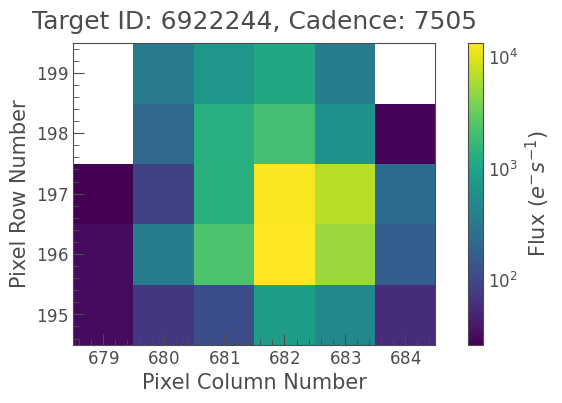

In [4]:
tpf.plot(frame=100, scale='log', show_colorbar=True)

We gebruiken de `to_lightcurve` methode om deze foto's om te zetten naar een `lightcurve`. Deze `lightcurve` bevat informatie over de hoeveelheid licht die we opvangen van de ster, doorheen de tijd.

In [5]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Hieronder plotten we de `lightcurve`. Valt er je iets op?

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

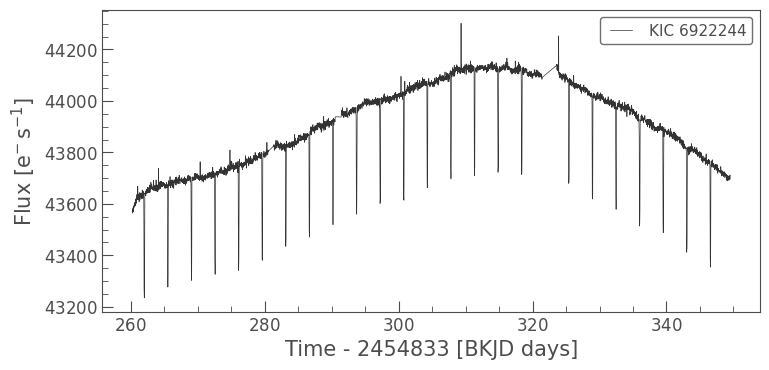

In [6]:
lc.plot()

Bovenstaande grafiek bevat een globaal verloop en mogelijks ook verschijnselen die periodiek terugkomen. Als er een periodieke daling is van de intensiteit, dan kan dit erop wijzen dat er een planeet rond de ster draait. 

Hieronder berekenen we via de `calculate_and_plot_trend` functie de `flattened_lc` en de `trend`. Het plot ook bovenstaande functie opnieuw, met daarbij een rode trendlijn. Deze rode trend is te wijten aan veranderingen in de hoek tussen het invallend licht van de ster en de teloscoop. De `flattened_lc` lightcurve verkrijgen we door de globale trend weg te filteren uit de data en kunnen we beschouwen als 'bruikbare data'.

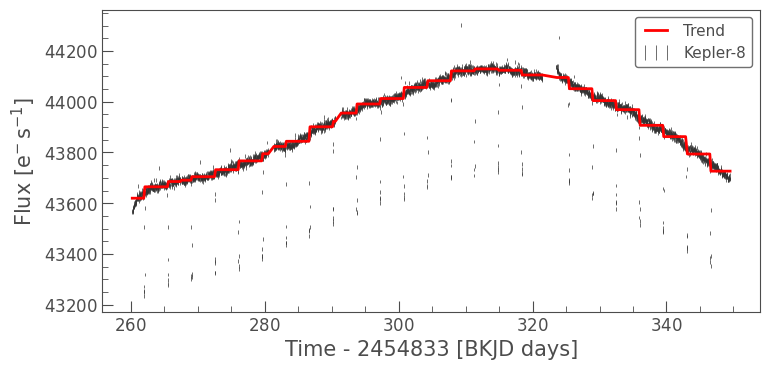

In [7]:
from helper import calculate_and_plot_trend
flattened_lc, trend = calculate_and_plot_trend(lc, star)

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

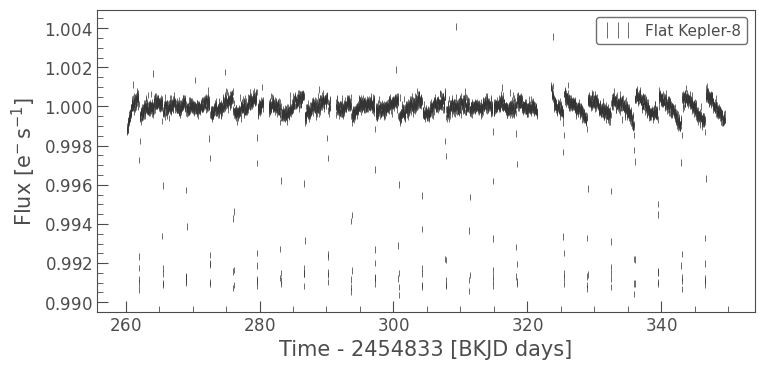

In [8]:
flattened_lc.errorbar(label="Flat " + star)

## Zoek de planeet

Hieronder gaan we een planeet zoeken door de kijken naar het `periodigram`. Dit periodigram toont hoe hard een specifieke periode (of frequentie) voorkomt in een functie.

Voordat we dit periodigram gaan opstellen, moeten we bepalen voor welke periodes we dit willen doen. De meeste missies van Kepler duurde ongeveer 90 dagen, wat is dan de maximale periode die we kunnen waarnemen met deze data?
Stel hieronder de minimale en maximale periode in die je wilt bekijken. Wijzig deze waarden later om specifieke periodes beter te kunnen onderzoeken

In [9]:
min_period = 1
max_period = 15

Hieronder plotten we het periodigram.

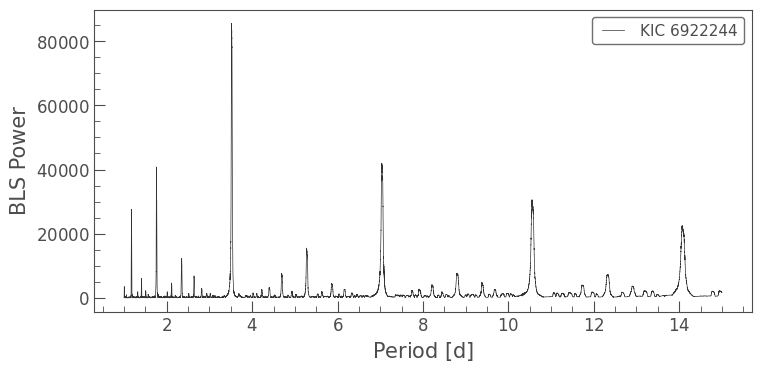

In [10]:
periodogram = flattened_lc.to_periodogram(method="bls", period=np.arange(min_period, max_period, 0.0001))
periodogram.plot();

We kunnen proberen om de periode met de hoogste piek, af te lezen van de bovenstaande grafiek. Dit zal echter niet zo nauwkeurig zijn. Het is daarom handig dat we die gegevens kunnen opvragen aan het periodogram.

In [11]:
    best_fit_period = periodogram.period_at_max_power
    print('Best fit period: {:.3f}'.format(best_fit_period))
    best_fit_duration = periodogram.duration_at_max_power
    print('Best fit duration: {:.3f}'.format(best_fit_duration))
    best_fit_depth = periodogram.depth_at_max_power
    print('Best fit depth: {:.3f}'.format(best_fit_depth))
    transit_time_at_max_power = periodogram.transit_time_at_max_power
    print('Best fit transit time: {:.3f}'.format(transit_time_at_max_power))


Best fit period: 3.517 d
Best fit duration: 0.250 d
Best fit depth: 0.004
Best fit transit time: 262.074


## Hebben we een planeet gevonden?

Hieronder gaan we controleren of de periode die we gevonden hebben, ook echt de data weerspiegeld. Om dit te doen gaan we de grafiek 'samenplooien' (of 'folden' in het engels). Wat betekent dit? Het betekent dat we een bepaald startpunt (de `offset`) gaan kiezen en een bepaalde periode en dat we aan de hand van die twee waardes en de functie, een nieuwe functie gaan maken met een bereik van -0.5 tot 0.5. 

Hoe maken we nu die nieuwe functie?
- We nemen het deel van de eerste functie vanaf het startpunt (de `offset`) tot `offset + periode` en kopiëren dit naar de nieuwe grafiek. We herschuiven (zodat het midden bij x=0 ligt) en schalen dit, zodat het past in het bereik -0.5 tot 0.5
- We delen de delen links en rechts van dit stukje op in stukken met een lengte gelijk aan `periode` en passen hierop deze verschuiving en schaling toe

In [12]:
fold_period = 3.517
fold_offset = 262.074

Voer het fold commando uit.

In [13]:
folded = flattened_lc.fold(period=fold_period, t0=fold_offset)

Plot de samengeplooide data via een scatterplot. Hoe zou dit er moeten uitzien voor een planeet?

<AxesSubplot:xlabel='Phase', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

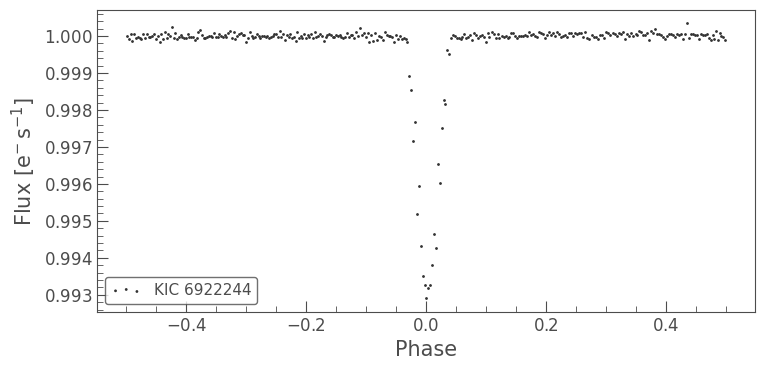

In [14]:
folded.bin().scatter()

We kunnen deze samengeplooide functie ook anders plotten, namelijk met een `rivierplot`. Op de y-as staat de cyclus (hoeveelste periodieke herhaling) en op de x as de fase (tussen -0.5 en 0.5). De kleur geeft waar wat de lichtintensiteit is. Hoe zou deze grafiek er moeten uitzien bij een planeet?

/home/jesse/.local/lib/python3.8/site-packages/lightkurve/lightcurve.py:1885: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


<AxesSubplot:title={'center':'KIC 6922244'}, xlabel='Phase', ylabel='Cycle'>

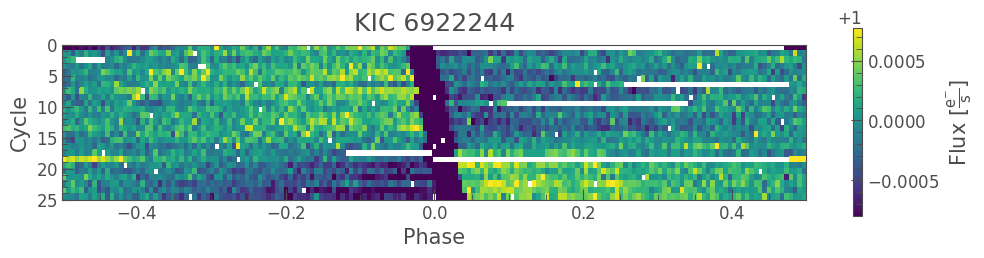

In [15]:
folded.plot_river()